In [ ]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'chest-xray-pneumonia:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F17810%2F23812%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240421%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240421T063630Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D66cd028342ce24cafff4ec74f5543b0f8eac53f767e6cbc694444e43e0dbe67d3d5138c6b6bde5a576e018044790e5893f74cfb4693d06e51ae21557a7aa043cef7a7024bd62d6a70f5add484c4ba346144a43eca63a7c33f9b2aa69392aefa46856e20e9cb7e1c31fbd2791b9c5742b0c3700e13fe51d352cf6b0b606066492f6196381ca9ee17073b8688b70b241f56769037d49effc73837f9d3e2030fb5b28433f2f82970c69894d73e550f2fd79880ed4dee7d94a45e5831dfffcf38235adbb92b632be5e7faee6b4a5db3c84fcfc8f01c83ca97b4bded3f1ca9ffe163dfb3aa59025792da991f9a90d3f895bf3bd64e058a6bf7ceab5867dc3e1a00c0b,pneumoniadata:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F907626%2F1538993%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240421%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240421T063630Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D28a426717eaf215a7ce61503f9e238db9cf728cd643e9ff067171f371482e880b1445cc649745dc8273fc14c744637e0c541838f1fd9a6dfcc470ddcc67e7b3fb3955c4172f5bfae461659c968f51b93da5cf8245a6adf8cdca230fcb1d14603aa820db1c1b3418de1f75a51c049d325e90ecc47d868158c888393ebdd33d78079fb2ead852e5187e91238e0850fa300b2dcb288a6134c1141dcb73bfd0a520d5d276543010a69a18a7eff9c0325dacbf2ec12805f8492534580acc0b6a74970c26efbfef82cda34f53f37ea69b302524982f8d58afe65cc58949103a39deed79b7da3a32733bfa1fc68c48550d9933edf1fc8c3826a34f33c5204a64589cc7e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2463365435 bytes downloaded
Downloaded and uncompressed: chest-xray-pneumonia
[==================================================] 60339 bytes downloaded
Downloaded and uncompressed: pneumoniadata
Data source import complete.


In [ ]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import glob # to find files

# Seaborn library for bar chart
import seaborn as sns

# Libraries for TensorFlow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers

# Library for Transfer Learning
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

print("Importing libraries completed.")

Importing libraries completed.


In [ ]:
# Declaring variables

# variables for data paths
path = '../input/chest-xray-pneumonia/chest_xray/'

# train directory
train_folder=path+"train/"
train_normal_dir=train_folder+"NORMAL/"
train_pneu_dir=train_folder+"PNEUMONIA/"
# test directory
test_folder=path+"test/"
test_normal_dir=test_folder+"NORMAL/"
test_pneu_dir=test_folder+"PNEUMONIA/"
# validation directory
val_folder=path+"val/"
val_normal_dir=val_folder+"NORMAL/"
val_pneu_dir=val_folder+"PNEUMONIA/"

# variables for image size
img_width=196
img_height=196

# variable for model
batch_size=64
epochs=10

print("Variable declaration completed.")

Variable declaration completed.


In [ ]:
# listing the folders containing images

# Train Dataset
train_class_names=os.listdir(train_folder)
print("Train class names: %s" % (train_class_names))
# print("\n")

# Test Dataset
test_class_names=os.listdir(test_folder)
print("Test class names: %s" % (test_class_names))
# print("\n")

# Validation Dataset
val_class_names=os.listdir(val_folder)
print("Validation class names: %s" % (val_class_names))

print("\nDataset class name listing completed.")

Train class names: ['NORMAL', 'PNEUMONIA']
Test class names: ['NORMAL', 'PNEUMONIA']
Validation class names: ['NORMAL', 'PNEUMONIA']

Dataset class name listing completed.


In [ ]:
# declaration of functions

# Function get name of xray type
def Get_Xray_Type(argument):
    switcher = {
        "NORMAL": "Normal",
        "PNEUMONIA": "Pneumonia",
    }
    return switcher.get(argument, "Invalid X-ray")
# Get_Xray_Type("NORMAL") # this is how the function can be called

print("Declaration of functions completed.")

Declaration of functions completed.


In [ ]:
# Analysis of Train, Test and Validation directory

# find all files, our files has extension jpeg
train_normal_cases = glob.glob(train_normal_dir + '*jpeg')
train_pneu_cases = glob.glob(train_pneu_dir + '*jpeg')

test_normal_cases = glob.glob(test_normal_dir + '*jpeg')
test_pneu_cases = glob.glob(test_pneu_dir + '*jpeg')

val_normal_cases = glob.glob(val_normal_dir + '*jpeg')
val_pneu_cases = glob.glob(val_pneu_dir + '*jpeg')

# create lists for train, test & validation cases, create labels as well
train_list = []
test_list = []
val_list = []

for x in train_normal_cases:
    train_list.append([x, "Normal"])

for x in train_pneu_cases:
    train_list.append([x, "Pneumonia"])

for x in test_normal_cases:
    test_list.append([x, "Normal"])

for x in test_pneu_cases:
    test_list.append([x, "Pneumonia"])

for x in val_normal_cases:
    val_list.append([x, "Normal"])

for x in val_pneu_cases:
    val_list.append([x, "Pneumonia"])

# create dataframes
train_df = pd.DataFrame(train_list, columns=['image', 'Diagnos'])
print(train_df.shape)
test_df = pd.DataFrame(test_list, columns=['image', 'Diagnos'])
print(test_df.shape)
val_df = pd.DataFrame(val_list, columns=['image', 'Diagnos'])
print(val_df.shape)

(5216, 2)
(624, 2)
(16, 2)


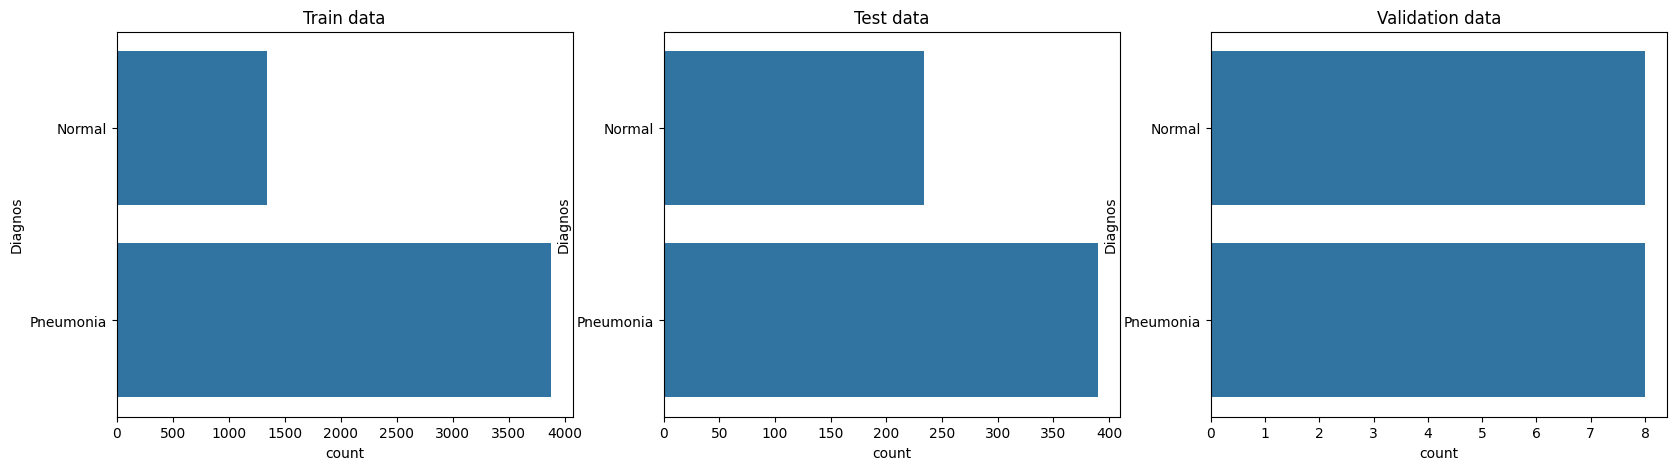

In [ ]:
# plotting the Train, Test and Validation image data

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(train_df['Diagnos'])
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(test_df['Diagnos'])
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(val_df['Diagnos'])
plt.title('Validation data')

plt.show()

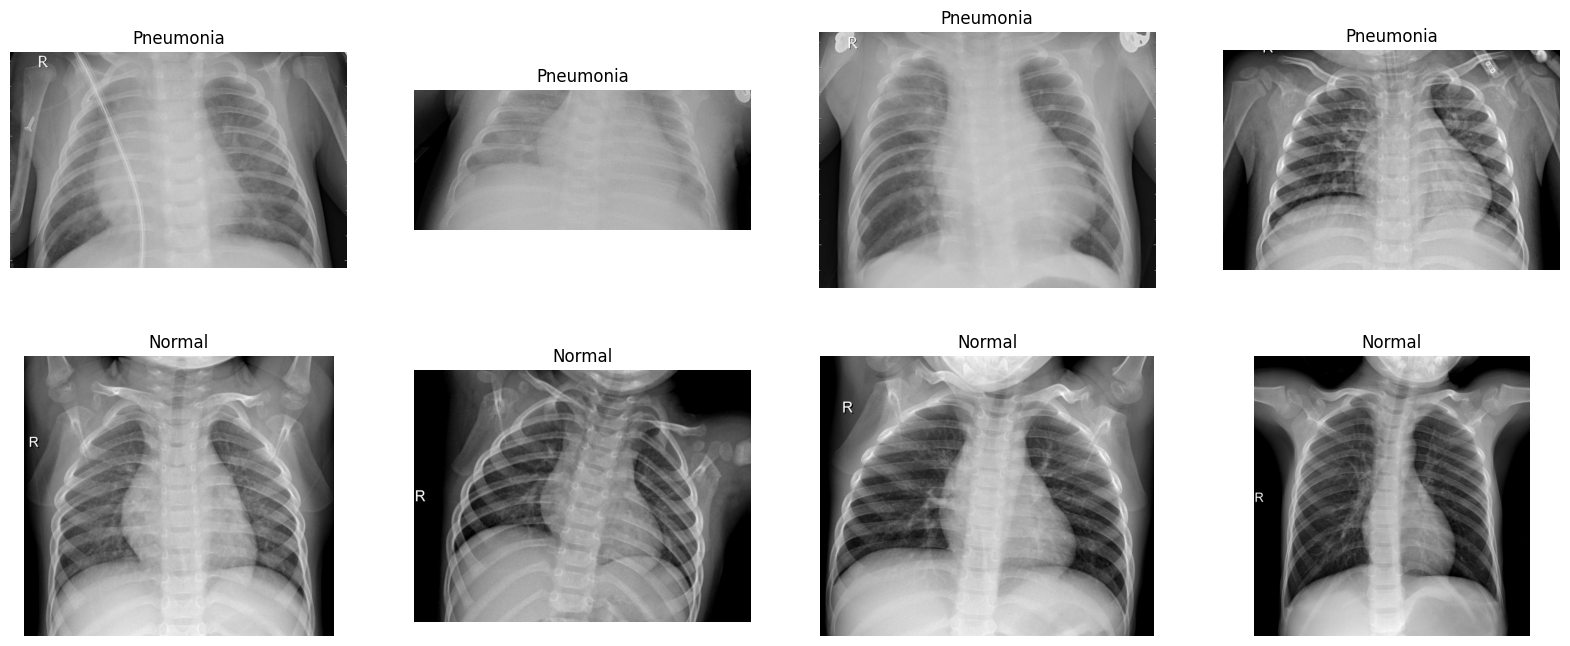

In [ ]:
# Plotting raw images just for review

plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df[train_df['Diagnos'] == "Pneumonia"][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')

for i,img_path in enumerate(train_df[train_df['Diagnos'] == "Normal"][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')

In [ ]:
# Preparing Training image data (image array and class name) for processing

# Declaring variables
x=[] # to store array value of the images
y=[] # to store the labels of the images

for folder in os.listdir(train_folder):
    image_list=os.listdir(train_folder+"/"+folder)
    for img_name in image_list:
        # Loading images
        img=image.load_img(train_folder+"/"+folder+"/"+img_name,target_size=(img_width,img_height))

        # Converting to arrary
        img=image.img_to_array(img)

        # Transfer Learning: this is to apply preprocess of VGG16 model to our images before passing it to VGG16
        img=preprocess_input(img) #  Optional step

        # Appending the arrarys
        x.append(img) # appending image array
        y.append(train_class_names.index(folder)) # appending class index to the array

print("Preparing Training Dataset Completed.")

Preparing Training Dataset Completed.


In [ ]:
# Preparing validation images data (image array and class name) for processing

# Declaring variables
val_images=[]
val_images_Original=[]
val_image_label=[] # to store the labels of the images

for folder in os.listdir(val_folder):
    image_list=os.listdir(val_folder+"/"+folder)
    for img_name in image_list:
        # Loading images
        img=image.load_img(val_folder+"/"+folder+"/"+img_name,target_size=(img_width,img_height))

        # Converting to arrarys
        img=image.img_to_array(img)

        # Saving original images, will be used just for display at the end
        val_images_Original.append(img.copy())

        # Transfer Learning: this is to apply preprocess of VGG16 to our images before passing it to VGG16
        img=preprocess_input(img) #  Optional step

        # Appending arrays
        val_images.append(img) # appending image array
        val_image_label.append(val_class_names.index(folder))

print("Preparing Validation Dataset Completed.")

Preparing Validation Dataset Completed.


In [ ]:
# Preparing validation images data (image array and class name) for processing

# Declaring variables
test_images=[]
test_images_Original=[]
test_image_label=[] # to store the labels of the images

for folder in os.listdir(test_folder):
    image_list=os.listdir(test_folder+"/"+folder)
    for img_name in image_list:
        # Loading images
        img=image.load_img(test_folder+"/"+folder+"/"+img_name,target_size=(img_width,img_height))

        # Converting to arrarys
        img=image.img_to_array(img)

        # Saving original images, will be used just for display at the end
        test_images_Original.append(img.copy())

        # Transfer Learning: this is to apply preprocess of VGG16 to our images before passing it to VGG16
        img=preprocess_input(img) #  Optional step

        # Appending arrays
        test_images.append(img) # appending image array
        test_image_label.append(test_class_names.index(folder))

print("Preparing Test Dataset Completed.")

Preparing Test Dataset Completed.


In [ ]:
# Verifying the output

# Training Dataset
print("Training Dataset")

x=np.array(x) # Converting to np arrary to pass to the model
print(x.shape)

y=to_categorical(y) # onehot encoding of the labels
# print(y)
print(y.shape)

# ===========

# Test Dataset
print("Test Dataset")

test_images=np.array(test_images)
print(test_images.shape)

test_image_label=to_categorical(test_image_label) # onehot encoding of the labels)
print(test_image_label.shape)

# ===========

# Validation Dataset
print("Validation Dataset")

val_images=np.array(val_images)
print(val_images.shape)

val_image_label=to_categorical(val_image_label) # onehot encoding of the labels)
print(val_image_label.shape)

Training Dataset
(5216, 196, 196, 3)
(5216, 2)
Test Dataset
(624, 196, 196, 3)
(624, 2)
Validation Dataset
(16, 196, 196, 3)
(16, 2)


In [ ]:
# Check properties of the model that we are going to use for Transfer Learning

print("Summary of default VGG16 model.\n")

# we are using VGG16 for transfer learnin here. So we have imported it
from tensorflow.keras.applications import VGG16

# initializing model with weights='imagenet'i.e. we are carring its original weights
model_vgg16=VGG16(weights='imagenet')

# display the summary to see the properties of the model
model_vgg16.summary()

Summary of default VGG16 model.

553467096/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                           

In [ ]:
# Modelling WITH Transfer Learning

# Here we will prepare model as per our requirements

print("Summary of Custom VGG16 model.\n")
print("1) We setup input layer and 2) We removed top (last) layer. \n")

# let us prepare our input_layer to pass our image size. default is (224,224,3). we will change it to (224,224,3)
input_layer=layers.Input(shape=(img_width,img_height,3))

# initialize the transfer model VGG16 with appropriate properties per our need.
# we are passing paramers as following
# 1) weights='imagenet' - Using this we are carring weights as of original weights.
# 2) input_tensor to pass the VGG16 using input_tensor
# 3) we want to change the last layer so we are not including top layer
model_vgg16=VGG16(weights='imagenet',input_tensor=input_layer,include_top=False)

# See the summary of the model with our properties.
model_vgg16.summary()

Summary of Custom VGG16 model.

1) We setup input layer and 2) We removed top (last) layer. 

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 196, 196, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 196, 196, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 196, 196, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 98, 98, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 98, 98, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None

In [ ]:
# access the current last layer of the model and add flatten and dense after it

print("Summary of Custom VGG16 model.\n")
print("1) We flatten the last layer and added 1 Dense layer and 1 output layer.\n")

last_layer=model_vgg16.output # we are taking last layer of the model

# Add flatten layer: we are extending Neural Network by adding flattn layer
flatten=layers.Flatten()(last_layer)

# Add dense layer
# dense1=layers.Dense(100,activation='relu')(flatten)

# Add dense layer to the final output layer
output_layer=layers.Dense(2,activation='softmax')(flatten)

# Creating modle with input and output layer
model=models.Model(inputs=input_layer,outputs=output_layer)

# Summarize the model
model.summary()

Summary of Custom VGG16 model.

1) We flatten the last layer and added 1 Dense layer and 1 output layer.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 196, 196, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 196, 196, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 196, 196, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 98, 98, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 98, 98, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 98, 98, 128)       147584    
                     

In [ ]:
# we will freez all the layers except the last layer

# we are making all the layers intrainable except the last layer
print("We are making all the layers intrainable except the last layer. \n")
for layer in model.layers[:-1]:
    layer.trainable=False
model.summary()

We are making all the layers intrainable except the last layer. 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 196, 196, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 196, 196, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 196, 196, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 98, 98, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 98, 98, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 98, 98, 128)       147584    
                                                             

In [ ]:
# Train the Model

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=5)
# print(xtrain)
# print(xtest)
# print(ytrain)
# print(ytest)

print("Splitting data for train and test completed.")

Splitting data for train and test completed.


In [ ]:
# Compiling Model

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

print("Model compilation completed.")

Model compilation completed.


In [ ]:
# Fit the Model

model.fit(xtrain,ytrain,epochs=epochs,batch_size=batch_size,verbose=True,validation_data=(xtest,ytest))

print("Fitting the model completed.")

Epoch 1/10
48/66 [====================>.........] - ETA: 8:11 - loss: 2.3503 - accuracy: 0.9046

In [ ]:
# This function helps to predict individual image supplied to it
def predict(img_name):
    img=image.load_img(img_name,target_size=(img_width,img_height))
    img=image.img_to_array(img)
    plt.imshow(img.astype('int32'))
    plt.show()
    img=preprocess_input(img)
#     plt.imshow(img.astype('int32'))
#     plt.show()
    prediction=model.predict(img.reshape(1,img_width,img_height,3))
    output=np.argmax(prediction)
    print(train_class_names[output] + ": " + Get_Xray_Type(train_class_names[output]))
#     print(train_class_names[output])
#     print(class_names_actual[output])



# This function plots the image supplied in array
def plot_image(i, predictions_array, true_label, img): # taking index and 3 arrays viz. prediction array, true label array and image array

    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.astype('int32'))

    predicted_label=np.argmax(predictions_array)
    true_label=np.argmax(true_label)

#     print(predicted_label)
#     print(true_label)

    if predicted_label == true_label: #setting up label color
        color='green' # correct then blue colour
    else:
        color='red' # wrong then red colour

#     predicted_class=val_class_names[predicted_label]
#     true_class=val_class_names[true_label]

    plt.xlabel("{} {:2.0f}% \n ({})".format(str(Get_Xray_Type(val_class_names[predicted_label])), 100*np.max(predictions_array), str(Get_Xray_Type(val_class_names[true_label])), color=color, horizontalalignment='left'))
#     plt.xlabel("{} {:2.0f}% ({})".format(val_class_names[predicted_label], 100*np.max(predictions_array), val_class_names[true_label]), color=color)

# This function plots bar chart supplied in the array data
def plot_value_array(i, predictions_array, true_label): # taking index along with predictions and true label array
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    predicted_label=np.argmax(predictions_array)
    true_label=np.argmax(true_label)
#     print(predicted_label)
#     print(true_label)
    if predicted_label == 0:
        predicted_label=1
    if true_label == 0:
        true_label=1

    thisplot=plt.bar(range(10), predicted_label, color='seashell')
    plt.ylim([0,1])

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

In [ ]:
# Preparing prediction arrary
val_predictions=[]

for img in val_images:
    img=img.reshape(1,img_width,img_height,3)
    val_predictions.append(model.predict(img))

test_predictions=[]

for img in test_images:
    img=img.reshape(1,img_width,img_height,3)
    test_predictions.append(model.predict(img))

In [ ]:
# Prediction of individual images taken from internet

# !wget -q https://prod-images-static.radiopaedia.org/images/25074651/ec1fa7072de87da7445f43ad54a784_jumbo.jpeg
predict('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg')

# white_headed_capuchin
# !wget -q https://drbeeneducation.files.wordpress.com/2016/09/posteriorv1-v11.png?resize=1113%2C886
predict('../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person108_bacteria_506.jpeg')

# japanese_macaque
# !wget -q https://hongkongliving.com/wp-content/uploads/2019/06/Monkey-Hill.jpg
predict('../input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg')

# patas_monkey
# !wget -q https://sambadenglish.com/wp-content/uploads/2019/05/Nilgiri-langur-1024x683.jpg
predict('../input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg')


# call the function

# defining parameters to pass to function
i=random.randrange(1,10) # image number 12. You may change value of i for play around
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
# we are passing "val_images_Original" just to show original image instead of "val_images"
# which is preprocessed as VGG16 process and used for prediction.
plot_image(i,val_predictions, val_image_label, val_images_Original)
plt.subplot(1,2,2)
plot_value_array(i, val_predictions, val_image_label)
plt.show()

In [ ]:
# Prediction on Test images

# Declaring variables
num_rows=4
num_cols=4
num_images=num_rows*num_cols

plt.figure(figsize=(2*2*num_cols,2*num_rows))

print("Classification of Test Chest X-ray into Normal and Pneumonia using Transfer Learning (VGG16)\n")
print("Predicted Diagnose, Percentage, (Original Diagnose)\n")

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
#     ii=random.randrange(1,227)
    # we are passing "val_images_Original" just to show original image instead of "val_images"
    # which is preprocessed as VGG16 process and used for prediction.
    indexer=random.randrange(1,624)
    plot_image(indexer,test_predictions, test_image_label, test_images_Original)

    plt.subplot(num_rows, 2*num_cols, 2*i+2)

    plot_value_array(indexer, test_predictions, test_image_label)
plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
# Prediction on Validation images

# Declaring variables
num_rows=4
num_cols=4
num_images=num_rows*num_cols

plt.figure(figsize=(2*2*num_cols,2*num_rows))

print("Classification of Chest X-ray into Normal and Pneumonia using Transfer Learning (VGG16)\n")
print("Predicted Species, Percentage, (Original Species)\n")

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
#     ii=random.randrange(1,227)
    # we are passing "val_images_Original" just to show original image instead of "val_images"
    # which is preprocessed as VGG16 process and used for prediction.
    plot_image(i,val_predictions, val_image_label, val_images_Original)

    plt.subplot(num_rows, 2*num_cols, 2*i+2)

    plot_value_array(i, val_predictions, val_image_label)
plt.subplots_adjust(hspace=0.5)
plt.show()